In [25]:
%load_ext autoreload
%autoreload 2

In [26]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [27]:
RESULT_DIR = 'results/'

In [28]:
files = os.listdir(RESULT_DIR)
files = sorted(files)
dfs = {}
for file in files:
    if '.txt' in file and 'jupyter' not in file:
        dfs['_'.join(file.split('.')[0].split('_')[:2])] = (pd.read_csv(RESULT_DIR + file))

In [29]:
dfs.keys()

dict_keys(['rtx8000_1', 'rtx8000_2', 'v100_1', 'v100_2'])

In [39]:
ttmse = {}
comm = {}
train = {}
total = {}
for k in dfs.keys():
    df = dfs[k]
    
    # get cumulative time
    df['Cumulative'] = df['Train Time'].cumsum()
    
    # calculate communication time 
    df['Comm'] = df['Total Time'] - df['Train Time']
    
    # store and print average communication, train and total time for each config
    avg_comm = df['Comm'].mean()
    avg_train = df['Train Time'].mean()
    avg_total = df['Total Time'].mean()
    print(k)
    print(f'Average Comm Time: {avg_comm}')
    print(f'Average Train Time: {avg_train}')
    print(f'Average Total Time: {avg_total}')
    train[k] = avg_train
    comm[k] = avg_comm
    total[k] = avg_total
    
    # get time to a MSE threshold, 0.125 in this case
    try:
        ttmse[k] = df[df['Val MSE'] <= 0.125].iloc[0].name
    except:
        ttmse[k] = None

rtx8000_1
Average Comm Time: 58.01894706693189
Average Train Time: 85.19479370939321
Average Total Time: 143.2137407763251
rtx8000_2
Average Comm Time: 62.24564269493367
Average Train Time: 201.53092056307298
Average Total Time: 263.77656325800666
v100_1
Average Comm Time: 65.39866625029465
Average Train Time: 76.4607699739522
Average Total Time: 141.85943622424685
v100_2
Average Comm Time: 82.05671381950378
Average Train Time: 195.6688552149411
Average Total Time: 277.7255690344449


In [32]:
ttmse

{'rtx8000_1': None, 'rtx8000_2': 28, 'v100_1': 26, 'v100_2': None}

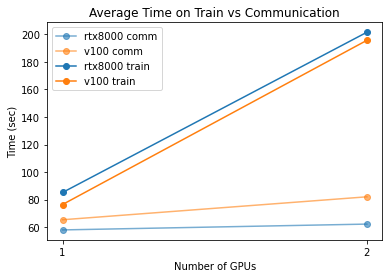

In [33]:
plt.figure(figsize=(6,4))
p1 = plt.plot([1,2], [comm['rtx8000_1'], comm['rtx8000_2']],label='rtx8000 comm',marker = 'o', alpha=0.6)
p2 = plt.plot([1,2], [comm['v100_1'], comm['v100_2']], label='v100 comm',marker = 'o', alpha=0.6)
plt.plot([1,2], [train['rtx8000_1'], train['rtx8000_2']],label='rtx8000 train',marker = 'o',c=p1[0].get_color())
plt.plot([1,2], [train['v100_1'], train['v100_2']], label='v100 train',marker = 'o',c=p2[0].get_color())
plt.xticks([1,2])
plt.xlabel('Number of GPUs')
plt.ylabel('Time (sec)')
plt.title('Average Time on Train vs Communication')
plt.legend()
plt.show()

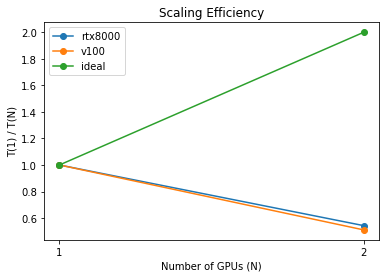

In [34]:
plt.figure(figsize=(6,4))
plt.plot([1,2], [1, total['rtx8000_1'] / total['rtx8000_2']],label='rtx8000',marker = 'o')
plt.plot([1,2], [1, total['v100_1'] / total['v100_2']], label='v100',marker = 'o')
plt.plot([1,2], [1, 2], label='ideal', marker='o')
plt.xticks([1,2])
plt.xlabel('Number of GPUs (N)')
plt.ylabel('T(1) / T(N)')
plt.title('Scaling Efficiency')
plt.legend()
plt.show()

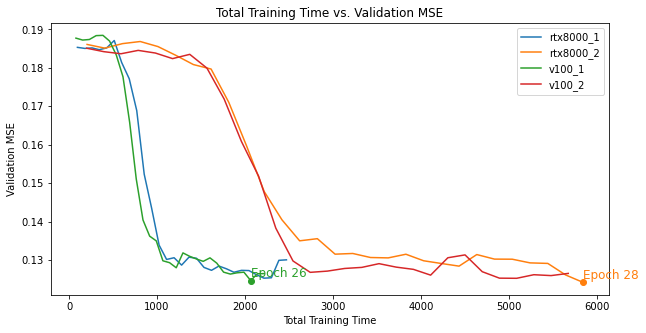

In [38]:
plt.figure(figsize=(10,5))
for k in dfs.keys():
    df = dfs[k]
    p = plt.plot(df['Cumulative'], df['Val MSE'], label = k)
    if ttmse[k] is not None:
        x = [df.iloc[ttmse[k]]['Cumulative']]
        y = [df.iloc[ttmse[k]]['Val MSE']]
        plt.plot(x, y, marker='o',c=p[0].get_color())
        plt.annotate('Epoch ' + str(ttmse[k]), (x[0], y[0]+0.001), c=p[0].get_color(),fontsize=12)
plt.xlabel('Total Training Time')
plt.ylabel('Validation MSE')
plt.title('Total Training Time vs. Validation MSE')
plt.legend()
plt.show()

In [40]:
# plt.figure(figsize=(6,4))
# plt.plot([1,2], [ratio['rtx8000_1'], ratio['rtx8000_2']],label='rtx8000',marker = 'o')
# plt.plot([1,2], [ratio['v100_1'], ratio['v100_2']], label='v100',marker = 'o')
# plt.xticks([1,2])
# plt.xlabel('Number of GPUs')
# plt.ylabel('Train Time / Total Time')
# plt.title('Train Time Ratio')
# plt.legend()
# plt.show()